# 01 - Подготовка данных для обнаружения сноубордиста

## Введение



Этот Jupyter Notebook подробно описывает процесс подготовки пользовательского датасета для задачи обнаружения сноубордистов. Основное внимание уделено стратегии сбора, курации, аннотирования и формирования финальной структуры данных, готовой для обучения модели YOLOv8.

Цель документации — представить принятые решения и реализованный пайплайн создания датасета, обеспечивающий качество и репрезентативность данных для последующего обучения модели.

**Примечание для читателя:**

Код, представленный в этом ноутбуке, преимущественно служит для **документирования и визуализации** результатов каждого этапа подготовки данных. Основная логика обработки данных реализована в отдельных Python-скриптах в директории `scripts/`. Вы можете сконцентрироваться текстовых ячейках и выводах, чтобы быстро ознакомиться с пайплайном и принятыми решениями.

## 1. Извлечение всех кадров из видео (`create_all_frames.py`)

Начальным этапом подготовки данных является извлечение всех кадров из исходного видео `resources/snowboard_day.mp4`. Это создает полный пул потенциальных изображений для дальнейшей курации и аннотирования.

Для выполнения этой задачи используется скрипт `scripts/create_all_frames.py`.

In [27]:
# Вывод кадров из all_frames
import os
import random
from IPython.display import Image, display, HTML, Markdown

output_dir = '../resources/all_frames'

all_frames_files = [f for f in os.listdir(output_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
all_frames_count = len(all_frames_files)

print(f"Общее количество извлеченных кадров в '{output_dir}': {all_frames_count}")

# --- Отображение нескольких примеров извлеченных кадров ---
if all_frames_count > 0:
    print("\nПримеры извлеченных кадров:")
    # Выбор до 5 случайных изображений
    example_images = random.sample(all_frames_files, min(5, all_frames_count))
    
    html_content = ""
    for img_name in example_images:
        img_path = os.path.join(output_dir, img_name)
        html_content += f'<img src="{img_path}" style="width:275px; margin-right: 10px; display:inline-block;" title="{img_name}">'
    
    display(HTML(html_content))
else:
    print("Невозможно отобразить примеры, так как папка с кадрами пуста.")

Общее количество извлеченных кадров в '../resources/all_frames': 675

Примеры извлеченных кадров:


## 2. Ручная курация данных и отбор данных для обучения (`train_val_raw`)

После извлечения всех кадров из видео следующим критически важным шагом стала **ручная курация данных**. Несмотря на большое количество кадров, не все они подходят для обучения модели детектирования объектов из-за размытости, отсутствия объекта, плохого ракурса или других факторов, снижающих качество.

Из `resources/all_frames/` было вручную отобрано **207 высококачественных кадров**, которые были перемещены в директорию `resources/train_val_raw/`. Этот процесс был основан на следующих критериях:

* **Наличие четкого сноубордиста:** Присутствие объекта интереса с достаточной детализацией.
* **Разнообразие поз:** Включение кадров со сноубордистом в различных позах (стоя, в движении, возможно, при падении), чтобы модель могла обобщать на разные состояния объекта.
* **Разнообразие условий:** Вариации в освещении (тени, яркое солнце), фонах (снег, деревья, небо) и ракурсах камеры относительно сноубордиста.
* **Сложные сценарии:** Включение кадров с частичными окклюзиями, разными масштабами сноубордиста в кадре и наличие красного жилета или его отсутствие.

Эти кадры составят основу для обучающей и валидационной выборок.

In [28]:
# Вывод кадров из train_val_raw
train_val_raw_dir = '../resources/train_val_raw'

train_val_raw_files = [f for f in os.listdir(train_val_raw_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
train_val_raw_count = len(train_val_raw_files)

print(f"Общее количество вручную отобранных кадров для Train/Validation в '{train_val_raw_dir}': {train_val_raw_count}")

# --- Отображение нескольких примеров отобранных кадров в строку ---
if train_val_raw_count > 0:
    print("\nПримеры отобранных кадров для обучения/валидации:")
    # Выбор до 5 случайных изображений (или меньше, если их мало)
    example_images = random.sample(train_val_raw_files, min(5, train_val_raw_count))
    
    html_content = ""
    for img_name in example_images:
        img_path = os.path.join(train_val_raw_dir, img_name)
        html_content += f'<img src="{img_path}" style="width:275px; margin-right: 10px; display:inline-block;" title="{img_name}">'
    
    display(HTML(html_content))
else:
    print("Папка с отобранными кадрами для Train/Validation пуста.")

Общее количество вручную отобранных кадров для Train/Validation в '../resources/train_val_raw': 207

Примеры отобранных кадров для обучения/валидации:


## 3. Создание независимого тестового набора (`test_raw`)

Для объективной и непредвзятой оценки финальной модели крайне важно иметь **независимый тестовый набор**, который модель **никогда не видела** в процессе обучения или валидации. Этот набор позволяет оценить истинную обобщающую способность модели на новых данных.

Из оставшихся кадров в `resources/all_frames/` (то есть тех, которые не были выбраны для `train_val_raw`) было вручную отобрано **63 уникальных кадра** для тестового набора. Эти кадры были помещены в директорию `resources/test_raw/`.

Для облегчения этого процесса отбора был использован вспомогательный скрипт `scripts/select_test_frames.py`. Он генерирует список кадров из `all_frames`, которые *не* были использованы в `train_val_raw`, что упрощает выборка новых кадров для теста.

Критерии отбора для тестового набора были аналогичны критериям для `train_val_raw` (качество изображения, наличие сноубордиста, разнообразие условий), но с обязательным условием отсутствия пересечения с `train_val_raw`.

In [29]:
# Вывод кадров из test_raw
test_raw_dir = '../resources/test_raw'

test_raw_files = [f for f in os.listdir(test_raw_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
test_raw_count = len(test_raw_files)

print(f"Общее количество вручную отобранных кадров для Test Set в '{test_raw_dir}': {test_raw_count}")

# --- Отображение нескольких примеров тестовых кадров ---
if test_raw_count > 0:
    print("\nПримеры тестовых кадров:")
    # Выбор до 5 случайных изображений (или меньше, если их мало)
    example_images = random.sample(test_raw_files, min(5, test_raw_count))
    
    html_content = ""
    for img_name in example_images:
        img_path = os.path.join(test_raw_dir, img_name)
        html_content += f'<img src="{img_path}" style="width:275px; margin-right: 10px; display:inline-block;" title="{img_name}">'
    
    display(HTML(html_content))
else:
    print("Папка с отобранными кадрами для Test Set пуста.")

Общее количество вручную отобранных кадров для Test Set в '../resources/test_raw': 63

Примеры тестовых кадров:


## 4. Аннотирование данных

После отбора всех релевантных изображений (как для `train_val_raw`, так и для `test_raw`), следующим шагом было их **ручное аннотирование**. Аннотирование включает в себя создание ограничивающих рамок (bounding boxes) вокруг объектов интереса и присвоение им соответствующего класса.

* **Инструмент разметки:** Для аннотирования использовался [LabelImg](https://github.com/HumanSignal/labelImg) (или укажите другой инструмент, если использовали, например, CVAT, Label Studio).
* **Формат аннотаций:** Все аннотации были сохранены в формате YOLO (`.txt` файлы), который является стандартным для обучения YOLOv8.
* **Централизованное хранение:** Все `.txt` файлы аннотаций, соответствующие как изображениям из `train_val_raw`, так и из `test_raw`, были сохранены в единой директории `resources/annotations/`. Это обеспечивает централизованное управление всеми созданными аннотациями.
* **Класс для разметки:** `snowboarder` (ID класса 0).
* **Правила разметки:** Ограничивающие рамки создавались вокруг **человека и его сноуборда**, максимально плотно охватывая оба элемента. Другие люди в кадре, не являющиеся основным объектом слежения, не размечались.

Пример размеченного изображения и его аннотации:
Изображение: frame_0431.jpg
Путь к аннотации: ../resources/annotations\frame_0431.txt


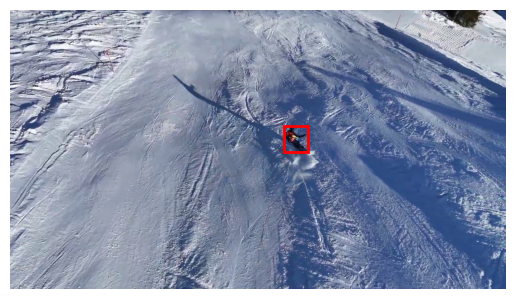


Содержимое файла аннотации (frame_0431.txt):


```txt
0 0.576302 0.462963 0.047396 0.094444

```

In [30]:
# Вывод примера аннотированного изображения из train_val_raw или test_raw
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.patches import Rectangle
from PIL import Image as PILImage

annotations_dir = '../resources/annotations'
train_val_raw_dir = '../resources/train_val_raw'
test_raw_dir = '../resources/test_raw'

# Выбираем случайное изображение для демонстрации
# Сначала попробуем взять из train_val_raw
image_files_to_sample_from = [f for f in os.listdir(train_val_raw_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
image_source_dir = train_val_raw_dir

# Если в train_val_raw пусто, или если хотим показать из test_raw
if not image_files_to_sample_from:
    image_files_to_sample_from = [f for f in os.listdir(test_raw_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    image_source_dir = test_raw_dir

if image_files_to_sample_from:
    sample_image_name = random.choice(image_files_to_sample_from)
    base_name = os.path.splitext(sample_image_name)[0]
    sample_image_path = os.path.join(image_source_dir, sample_image_name)
    sample_annotation_path = os.path.join(annotations_dir, base_name + '.txt')

    print(f"Пример размеченного изображения и его аннотации:")
    print(f"Изображение: {sample_image_name}")
    print(f"Путь к аннотации: {sample_annotation_path}")

    # Отображаем изображение с рамками
    try:
        img_pil = PILImage.open(sample_image_path)
        img_width, img_height = img_pil.size

        fig, ax = plt.subplots(1)
        ax.imshow(img_pil)
        ax.axis('off')

        if os.path.exists(sample_annotation_path):
            with open(sample_annotation_path, 'r') as f:
                lines = f.readlines()
                for line in lines:
                    parts = list(map(float, line.strip().split()))
                    # Формат YOLO: class_id, x_center, y_center, width, height (все нормализованы)
                    # Конвертировать в формат Matplotlib (x_min, y_min, width, height)
                    x_center, y_center, bbox_width, bbox_height = parts[1:]
                    
                    # Денормализовать и преобразовать в верхний левый угол
                    x_min = (x_center - bbox_width / 2) * img_width
                    y_min = (y_center - bbox_height / 2) * img_height
                    bbox_pixel_width = bbox_width * img_width
                    bbox_pixel_height = bbox_height * img_height

                    rect = Rectangle((x_min, y_min), bbox_pixel_width, bbox_pixel_height,
                                     linewidth=2, edgecolor='r', facecolor='none')
                    ax.add_patch(rect)
            plt.show()
            
            # Отображаем содержимое .txt файла
            print(f"\nСодержимое файла аннотации ({base_name}.txt):")
            with open(sample_annotation_path, 'r') as f:
                annotation_content = f.read()
                display(Markdown(f"```txt\n{annotation_content}\n```"))
        else:
            print(f"Файл аннотации {sample_annotation_path} не найден.")
            display(Image(filename=sample_image_path, width=400))
            plt.show()
            

    except FileNotFoundError:
        print(f"Изображение {sample_image_name} не найдено в {image_source_dir}.")
        
else:
    print("Невозможно выбрать пример, так как папки train_val_raw и test_raw пусты.")

## 5. Разделение данных на Train/Validation (`split_train_val.py`)

После курации и аннотирования изображений следующим шагом стало разделение основного набора `resources/train_val_raw/` на обучающую (`train`) и валидационную (`val`) выборки. Это стандартная практика в машинном обучении, позволяющая:

* **Обучающая выборка:** Используется для непосредственного обучения модели.
* **Валидационная выборка:** Используется для отслеживания прогресса обучения, настройки гиперпараметров и предотвращения переобучения, не влияя при этом на финальную, независимую оценку модели.

Для автоматизации этого процесса был использован скрипт `scripts/split_train_val.py`. Скрипт случайным образом разделяет изображения и их соответствующие аннотации в соотношении 80% для обучения и 20% для валидации. Результаты сохраняются в `resources/dataset/images/{train,val}/` и `resources/dataset/labels/{train,val}/`.

In [32]:
import shutil

BASE_DATASET_DIR = '../resources/dataset'
TRAIN_IMAGES_DIR = os.path.join(BASE_DATASET_DIR, 'images', 'train')
VAL_IMAGES_DIR = os.path.join(BASE_DATASET_DIR, 'images', 'val')
TRAIN_LABELS_DIR = os.path.join(BASE_DATASET_DIR, 'labels', 'train')
VAL_LABELS_DIR = os.path.join(BASE_DATASET_DIR, 'labels', 'val')

print(f"Проверка содержимого train/val после запуска scripts/split_train_val.py:")

train_images_count = len([f for f in os.listdir(TRAIN_IMAGES_DIR) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]) if os.path.exists(TRAIN_IMAGES_DIR) else 0
val_images_count = len([f for f in os.listdir(VAL_IMAGES_DIR) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]) if os.path.exists(VAL_IMAGES_DIR) else 0
train_labels_count = len([f for f in os.listdir(TRAIN_LABELS_DIR) if f.lower().endswith(('.txt'))]) if os.path.exists(TRAIN_LABELS_DIR) else 0
val_labels_count = len([f for f in os.listdir(VAL_LABELS_DIR) if f.lower().endswith(('.txt'))]) if os.path.exists(VAL_LABELS_DIR) else 0

print(f"Обучающая выборка (images): {train_images_count} изображений")
print(f"Обучающая выборка (labels): {train_labels_count} аннотаций")
print(f"Валидационная выборка (images): {val_images_count} изображений")
print(f"Валидационная выборка (labels): {val_labels_count} аннотаций")

if train_images_count == train_labels_count and val_images_count == val_labels_count:
    print("\nКоличество изображений и аннотаций в Train/Val совпадает. Разделение выполнено корректно.")
else:
    print("\nВнимание: Количество изображений и аннотаций в Train/Val НЕ совпадает. Проверьте скрипт 'split_train_val.py'.")

Проверка содержимого train/val после запуска scripts/split_train_val.py:
Обучающая выборка (images): 166 изображений
Обучающая выборка (labels): 166 аннотаций
Валидационная выборка (images): 41 изображений
Валидационная выборка (labels): 41 аннотаций

Количество изображений и аннотаций в Train/Val совпадает. Разделение выполнено корректно.


## 6. Копирование тестовых данных в финальную структуру (`copy_test_data.py`)

Последним шагом в формировании датасета является копирование независимого тестового набора (`resources/test_raw/`) и его аннотаций в соответствующую директорию финальной структуры датасета (`resources/dataset/images/test/` и `resources/dataset/labels/test/`).

Для выполнения этой операции используется скрипт `scripts/copy_test_data.py`. Этот скрипт гарантирует, что тестовые данные аккуратно размещены для дальнейшего использования в процессе финальной оценки модели, не смешиваясь с обучающими/валидационными данными.

In [34]:
BASE_DATASET_DIR = '../resources/dataset'
TEST_IMAGES_DIR = os.path.join(BASE_DATASET_DIR, 'images', 'test')
TEST_LABELS_DIR = os.path.join(BASE_DATASET_DIR, 'labels', 'test')

print(f"Проверка содержимого test после запуска scripts/copy_test_data.py:")

test_images_count = len([f for f in os.listdir(TEST_IMAGES_DIR) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]) if os.path.exists(TEST_IMAGES_DIR) else 0
test_labels_count = len([f for f in os.listdir(TEST_LABELS_DIR) if f.lower().endswith(('.txt'))]) if os.path.exists(TEST_LABELS_DIR) else 0

print(f"Тестовая выборка (images): {test_images_count} изображений")
print(f"Тестовая выборка (labels): {test_labels_count} аннотаций")

if test_images_count == test_labels_count:
    print("\nКоличество изображений и аннотаций в Test Set совпадает. Копирование выполнено корректно.")
else:
    print("\nВнимание: Количество изображений и аннотаций в Test Set НЕ совпадает. Проверьте скрипт 'copy_test_data.py'.")

Проверка содержимого test после запуска scripts/copy_test_data.py:
Тестовая выборка (images): 63 изображений
Тестовая выборка (labels): 63 аннотаций

Количество изображений и аннотаций в Test Set совпадает. Копирование выполнено корректно.


## 7. Финальная структура датасета и конфигурация `dataset.yaml`

После выполнения всех этапов извлечения, курации, аннотирования и разделения данных, финальный датасет для обучения модели YOLOv8 имеет следующую структуру и полностью готов к использованию в тренировочном пайплайне YOLOv8.

Все собранные и обработанные данные находятся в директории `resources/dataset/`, которая организована следующим образом:

```esources/dataset/
├── images/
│   ├── train/  (изображения для обучения)
│   ├── val/    (изображения для валидации)
│   └── test/   (изображения для тестирования)
└── labels/
├── train/  (аннотации для обучения)
├── val/    (аннотации для валидации)
└── test/   (аннотации для тестирования)```

Конфигурация датасета для YOLOv8 задается в файле `resources/dataset.yaml`, который указывает пути к обучающим, валидационным и тестовым изображениям, а также информацию о классах.

## **8. Выводы по подготовке данных**

Таким образом, этап подготовки данных для проекта "Автономное слежение за сноубордистом" успешно завершен. Мы прошли путь от извлечения всех кадров из исходного видео до формирования чистого, аннотированного и структурированного датасета, готового к использованию для обучения модели обнаружения объектов YOLOv8.

**Ключевые результаты этого этапа:**

* **Полный пул кадров:** Извлечено 675 кадров из видео `snowboard_day.mp4`.
* **Качественная курация:** Вручную отобрано 270 высококачественных изображений, обеспечивающих разнообразие и репрезентативность для обучения и тестирования.
* **Детальная аннотация:** Все отобранные изображения были точно аннотированы в формате YOLO, сфокусировавшись на классе `snowboarder` (человек + сноуборд).
* **Надежное разделение данных:** Датасет структурирован с четким разделением на обучающую (166 изображений), валидационную (41 изображение) и независимую тестовую (63 изображения) выборки, что критически важно для корректной оценки производительности модели.
* **Готовность к обучению:** Финальная структура данных и конфигурация `dataset.yaml` полностью соответствуют требованиям Ultralytics YOLOv8.